# ***Import Necessary Libraries***

In [22]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Flatten, Activation, Dense, BatchNormalization
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ***Read Images and labels into Workspace***

In [3]:
img_size = 224

In [4]:
def readImagesAndLabels(filePath):
  images = []
  labels = []
  for image in os.listdir(filePath):
    temp = cv2.imread(filePath + "/" + image)[...,::-1]  # Convert BGR to RGB format
    resized_arr = cv2.resize(temp, (img_size, img_size)) # Reshaping images to preferred size
    
    labels.append(image.split('.')[0])
    images.append(resized_arr)
  return images, labels

# ***Split Data into Equal Ratios***

In [5]:
def splitData(images, labels, trainList):
  X_train = []
  y_train = []
  X_test = []
  y_test = []

  combined = list(zip(images, labels))
  random.shuffle(combined)
  shuffledImages, shuffledLabels = zip(*combined)

  for i in range(len(shuffledLabels)):
    if shuffledLabels[i] == "Cofield":
      if trainList[0] > 0:
        X_train.append(shuffledImages[i])
        y_train.append(shuffledLabels[i])
        trainList[0] = trainList[0] - 1
      else:
        X_test.append(shuffledImages[i])
        y_test.append(shuffledLabels[i])
    elif shuffledLabels[i] == "Depuy":
      if trainList[1] > 0:
        X_train.append(shuffledImages[i])
        y_train.append(shuffledLabels[i])
        trainList[1] = trainList[1] - 1
      else:
        X_test.append(shuffledImages[i])
        y_test.append(shuffledLabels[i])
    elif shuffledLabels[i] == "Tornier":
      if trainList[2] > 0:
        X_train.append(shuffledImages[i])
        y_train.append(shuffledLabels[i])
        trainList[2] = trainList[2] - 1
      else:
        X_test.append(shuffledImages[i])
        y_test.append(shuffledLabels[i])
    else:
      if trainList[3] > 0:
        X_train.append(shuffledImages[i])
        y_train.append(shuffledLabels[i])
        trainList[3] = trainList[3] - 1
      else:
        X_test.append(shuffledImages[i])
        y_test.append(shuffledLabels[i])
  return X_train, y_train, X_test, y_test

In [6]:
def encodeLabels(labels):
  labelDict = {
    "Cofield" : [1, 0, 0, 0], "Depuy" : [0, 1, 0, 0], "Tornier" : [0, 0, 1, 0], "Zimmer" : [0, 0, 0, 1]
    }
  encoded = []
  for label in labels:
    if label == "Cofield":
      encoded.append(labelDict["Cofield"])
    elif label == "Depuy":
      encoded.append(labelDict["Depuy"])
    elif label == "Tornier":
      encoded.append(labelDict["Tornier"])
    else:
      encoded.append(labelDict["Zimmer"])
  return encoded

# ***Data Standardization***

In [7]:
def Standardize(X_train, X_test):
  X_train = np.array(X_train).astype('float32')
  X_test = np.array(X_test).astype('float32')

  trainMean, trainStd = X_train.mean(), X_train.std()
  testMean, testStd = X_test.mean(), X_test.std()


  X_train = (X_train - trainMean) / trainStd 
  X_test = (X_test - testMean) / testStd

  trainMean, trainStd = X_train.mean(), X_train.std()
  testMean, testStd = X_test.mean(), X_test.std()
  print("Train Mean: %.3f, Train Standard Deviation: %.3f" % (trainMean, trainStd))
  print("Test Mean: %.3f, Test Standard Deviation: %.3f" % (testMean, testStd))
  return X_train, X_test

# ***Apply Augmentation to our Data***

In [8]:
def AugmentData(X_train, X_test, encodedTrainLabels, encodedTestLabels, model, epochs, batch_size, verbose, es):
  datagen = ImageDataGenerator(
      #rescale = 1. / 255,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

  datagen.fit(X_train)
  #datagen.fit(X_test)
  # fits the model on batches with real-time data augmentation:
  history = model.fit(datagen.flow(X_train, encodedTrainLabels, batch_size = batch_size),
          validation_data = (X_test, encodedTestLabels),
          steps_per_epoch = len(X_train) // 32, epochs = epochs, verbose = verbose, callbacks = [es])
  return history

# ***Building CNN Model***

In [9]:
def build_Model():
    # Create model

    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3, 3), input_shape=(224, 224, 3), activation = 'relu'))
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    #model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    #model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(2, 2))
    #model.add(Dropout(0.2))

    #model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
    #model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(2, 2))
    #model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    
    # Compile the Model
    #opti = Adam(learning_rate = 1e-4)

    # Learning rate decay / scheduling
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-4,
    decay_steps = 10000,
    decay_rate = 0.9)
    opti = keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9)
    #opti = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics=['accuracy'])
    return model

# ***Getting Predictions***

In [10]:
def predict(model, X_test):
  predictions = model.predict(X_test)
  pred = np.argmax(predictions, axis = 1)
  TestLabels = np.argmax(encodedTestLabels, axis = 1)
  print(classification_report(TestLabels, pred))

# ***Visualizing the Outputs***

In [11]:
def visualize(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.5)
  plt.show()

# ***Evaluating our Model***

In [12]:
def evaluate(model, X_test, encodedTestLabels):
  model.evaluate(X_test, encodedTestLabels)

# ***Functions Calling***

In [13]:
images, labels = readImagesAndLabels("/content/gdrive/MyDrive/data")

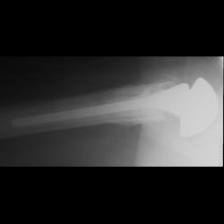

Depuy


In [14]:
index = random.randint(0, len(images) + 1)
cv2_imshow(images[index])
print(labels[index])

In [15]:
trainRatio = 0.75
#testRatio = 0.25

trainList = [int(labels.count("Cofield") * trainRatio), int(labels.count("Depuy") * trainRatio),
              int(labels.count("Tornier") * trainRatio), int(labels.count("Zimmer") * trainRatio)]

print("Length of Training Samples: {}".format(sum(trainList)))
print("Length of Testing Samples: {}".format(len(images) - sum(trainList)))
print("Count of each Class in Train: {}".format(trainList))

X_train, y_train, X_test, y_test = splitData(images, labels, trainList)
print(len(X_train) + len(X_test))
print(len(y_train) + len(y_test))
print(len(X_train) == len(y_train))
print(len(X_test) == len(y_test))

Length of Training Samples: 446
Length of Testing Samples: 151
Count of each Class in Train: [62, 220, 53, 111]
597
597
True
True


In [16]:
encodedTrainLabels = encodeLabels(y_train)
encodedTestLabels = encodeLabels(y_test)

In [17]:
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

X_train.reshape(-1, img_size, img_size, 1)
encodedTrainLabels = np.array(encodedTrainLabels)

X_test.reshape(-1, img_size, img_size, 1)
encodedTestLabels = np.array(encodedTestLabels)

In [18]:
model = build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 flatten (Flatten)           (None, 387200)            0         
                                                                 
 dense (Dense)               (None, 256)               99123456  
                                                        

# ***Without Augmentation***

In [19]:
epochs = 20
batch_size = 8
verbose = 1

# Early stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = verbose, patience = 9)

X_train, X_test = Standardize(X_train, X_test)

history = model.fit(X_train, encodedTrainLabels,
                    validation_split = 0.2, epochs = epochs,
                    batch_size = batch_size, verbose = verbose,
                    callbacks = [es])

Train Mean: 0.000, Train Standard Deviation: 1.000
Test Mean: 0.000, Test Standard Deviation: 1.000
Epoch 1/20
45/45 [==============================] - 17s 110ms/step - loss: 1.3494 - accuracy: 0.4663 - val_loss: 1.1947 - val_accuracy: 0.5333
Epoch 2/20
45/45 [==============================] - 4s 89ms/step - loss: 1.2151 - accuracy: 0.4831 - val_loss: 1.2088 - val_accuracy: 0.5000
Epoch 3/20
45/45 [==============================] - 4s 88ms/step - loss: 1.1112 - accuracy: 0.5337 - val_loss: 1.1624 - val_accuracy: 0.5556
Epoch 4/20
45/45 [==============================] - 4s 89ms/step - loss: 1.0760 - accuracy: 0.5478 - val_loss: 1.1876 - val_accuracy: 0.5444
Epoch 5/20
45/45 [==============================] - 4s 89ms/step - loss: 1.0280 - accuracy: 0.5702 - val_loss: 1.2080 - val_accuracy: 0.4889
Epoch 6/20
45/45 [==============================] - 4s 94ms/step - loss: 0.9984 - accuracy: 0.5787 - val_loss: 1.2301 - val_accuracy: 0.5111
Epoch 7/20
45/45 [==============================] - 

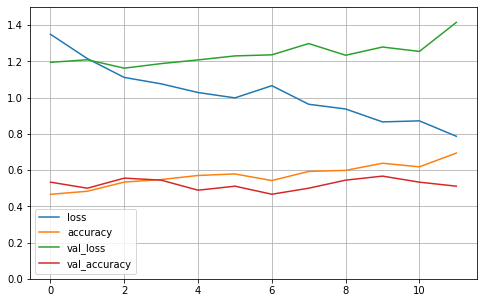

In [23]:
visualize(history)

In [24]:
evaluate(model, X_test, encodedTestLabels)

5/5 [==============================] - 2s 176ms/step - loss: 1.3597 - accuracy: 0.4702


In [25]:
predict(model, X_test)

              precision    recall  f1-score   support

           0       1.00      0.10      0.17        21
           1       0.55      0.72      0.62        74
           2       0.50      0.06      0.10        18
           3       0.29      0.39      0.34        38

    accuracy                           0.47       151
   macro avg       0.59      0.32      0.31       151
weighted avg       0.54      0.47      0.43       151



In [26]:
#model.save("my_model.h5")

# ***With Augmentation***

In [27]:
epochs = 20
batch_size = 32
verbose = 1

# Early stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = verbose, patience = 9)

history = AugmentData(X_train, X_test, encodedTrainLabels, encodedTestLabels, model, epochs, batch_size, verbose, es)

Epoch 1/20
13/13 [==============================] - 9s 662ms/step - loss: 1.2097 - accuracy: 0.5242 - val_loss: 1.2532 - val_accuracy: 0.5298
Epoch 2/20
13/13 [==============================] - 7s 482ms/step - loss: 1.1627 - accuracy: 0.5193 - val_loss: 1.2086 - val_accuracy: 0.4834
Epoch 3/20
13/13 [==============================] - 6s 423ms/step - loss: 1.1570 - accuracy: 0.5288 - val_loss: 1.1943 - val_accuracy: 0.4901
Epoch 4/20
13/13 [==============================] - 6s 423ms/step - loss: 1.0796 - accuracy: 0.5386 - val_loss: 1.1947 - val_accuracy: 0.4967
Epoch 5/20
13/13 [==============================] - 6s 421ms/step - loss: 1.1021 - accuracy: 0.5411 - val_loss: 1.1886 - val_accuracy: 0.5166
Epoch 6/20
13/13 [==============================] - 6s 421ms/step - loss: 1.0727 - accuracy: 0.5314 - val_loss: 1.1725 - val_accuracy: 0.5695
Epoch 7/20
13/13 [==============================] - 6s 422ms/step - loss: 1.0777 - accuracy: 0.5773 - val_loss: 1.1615 - val_accuracy: 0.4901
Epoch 

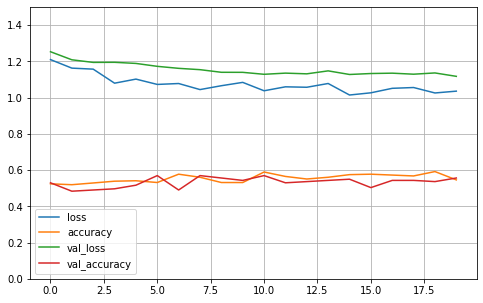

In [28]:
visualize(history)

In [29]:
evaluate(model, X_test, encodedTestLabels)

5/5 [==============================] - 0s 52ms/step - loss: 1.1173 - accuracy: 0.5563


In [30]:
predict(model, X_test)

              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.56      0.86      0.68        74
           2       0.20      0.06      0.09        18
           3       0.42      0.21      0.28        38

    accuracy                           0.56       151
   macro avg       0.51      0.41      0.42       151
weighted avg       0.52      0.56      0.50       151



In [31]:
#model.save("my_model.h5")